Text(0.5, 1.0, 'Original Image')

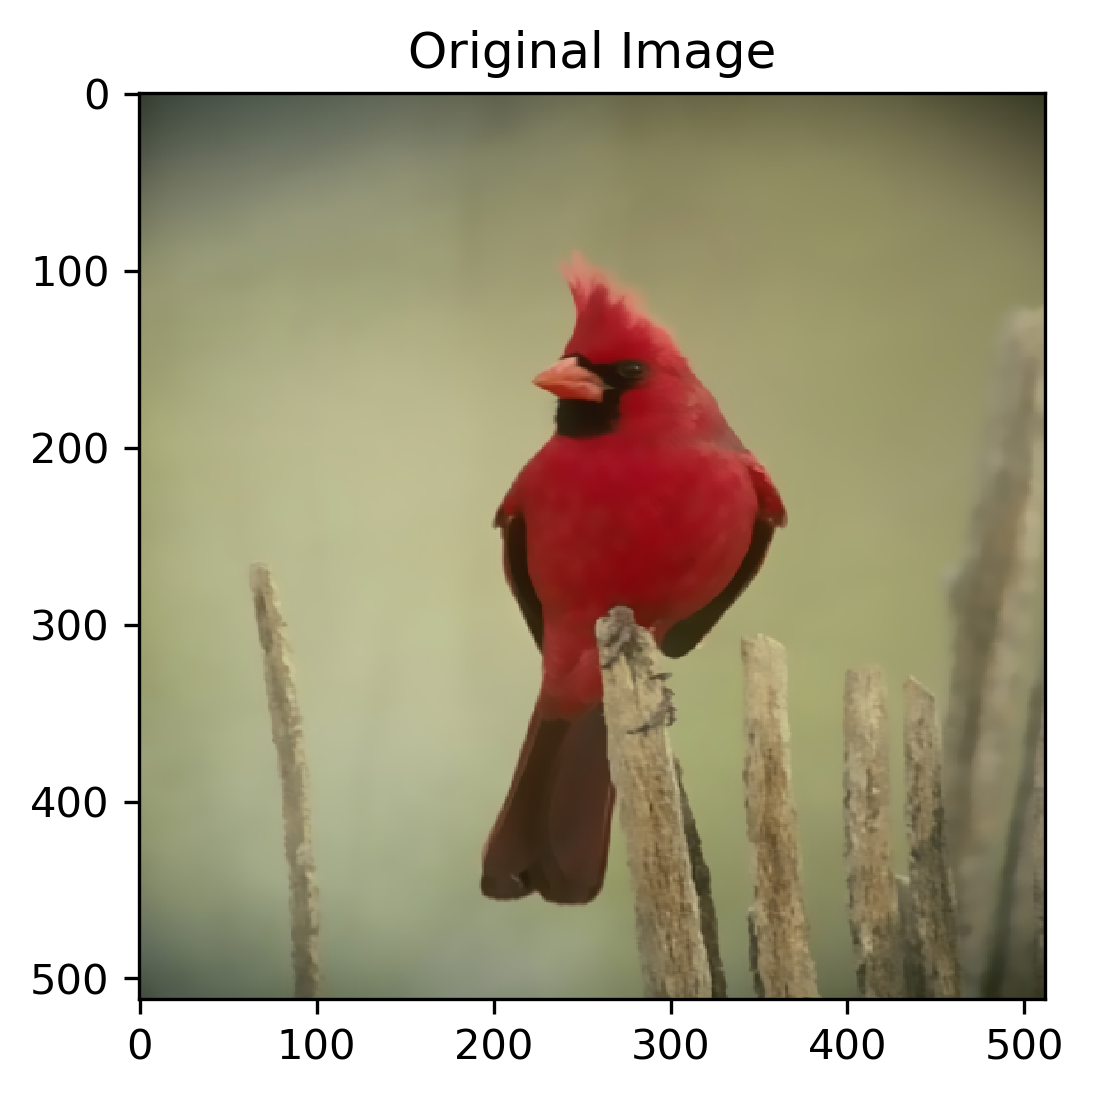

In [8]:
import os
# Select 1 GPU ID if you have hihg memory gpu else run on all available GPUs
#os.environ['CUDA_VISIBLE_DEVICES'] = str(3)  
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from tqdm import trange
import cv2
import numpy as np
np.random.seed(1943)
from skimage import segmentation
from torchsummary import summary
from model import SEEK
import torch

######################################
#       Set Hyperparameter Values
######################################
input_image_path = '/home/user01/data_ssd/Talha/BSID500/(477).jpg' 
# Resize
img_w = 512
img_h = 512
Epoch = 64 # select the epochs in power of two
init_lr = 5e-2
feature_maps = 128   # Feature maps (i.e. C) for SE_blocks
min_label_num = 2    # if the label number small than min_label_num, we'll stop iterations
max_label_num = 256  

'''
First we will read and preporcess the image and then pass it through superpixel
based segmentation methods, we can use either 'Felzenszwalb' or 'SLIC'.

The optimized values for both alogrithms are tunned via Grid_search on BSDS500.
'''

image = cv2.imread(input_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (img_h, img_w))

image = cv2.bilateralFilter(image, 11, sigmaSpace = 50, sigmaColor = 28)
plt.imshow(image)
plt.title('Original Image')


Generating Segments [Epoch(s) Done]:   0%|          | 0/64 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 512, 512]           3,456
       BatchNorm2d-2        [-1, 128, 512, 512]             256
              ReLU-3        [-1, 128, 512, 512]               0
            Conv2d-4        [-1, 128, 512, 512]          16,384
       BatchNorm2d-5        [-1, 128, 512, 512]             256
              ReLU-6        [-1, 128, 512, 512]               0
            Conv2d-7         [-1, 64, 512, 512]          73,728
       BatchNorm2d-8         [-1, 64, 512, 512]             128
              ReLU-9         [-1, 64, 512, 512]               0
           Conv2d-10        [-1, 128, 512, 512]           8,192
      BatchNorm2d-11        [-1, 128, 512, 512]             256
             ReLU-12        [-1, 128, 512, 512]               0
           Linear-13             [-1, 1, 1, 16]           2,064
             ReLU-14             [-1, 1

Generating Segments [Epoch(s) Done]: 100%|██████████| 64/64 [00:16<00:00,  3.77it/s]


**************************************************
Loss after 64 Epoch(s)             = 0.08
PyTorch Initilization time         = 17.13 second(s)
Time Taken for generating segments = 17.10 second(s)
**************************************************


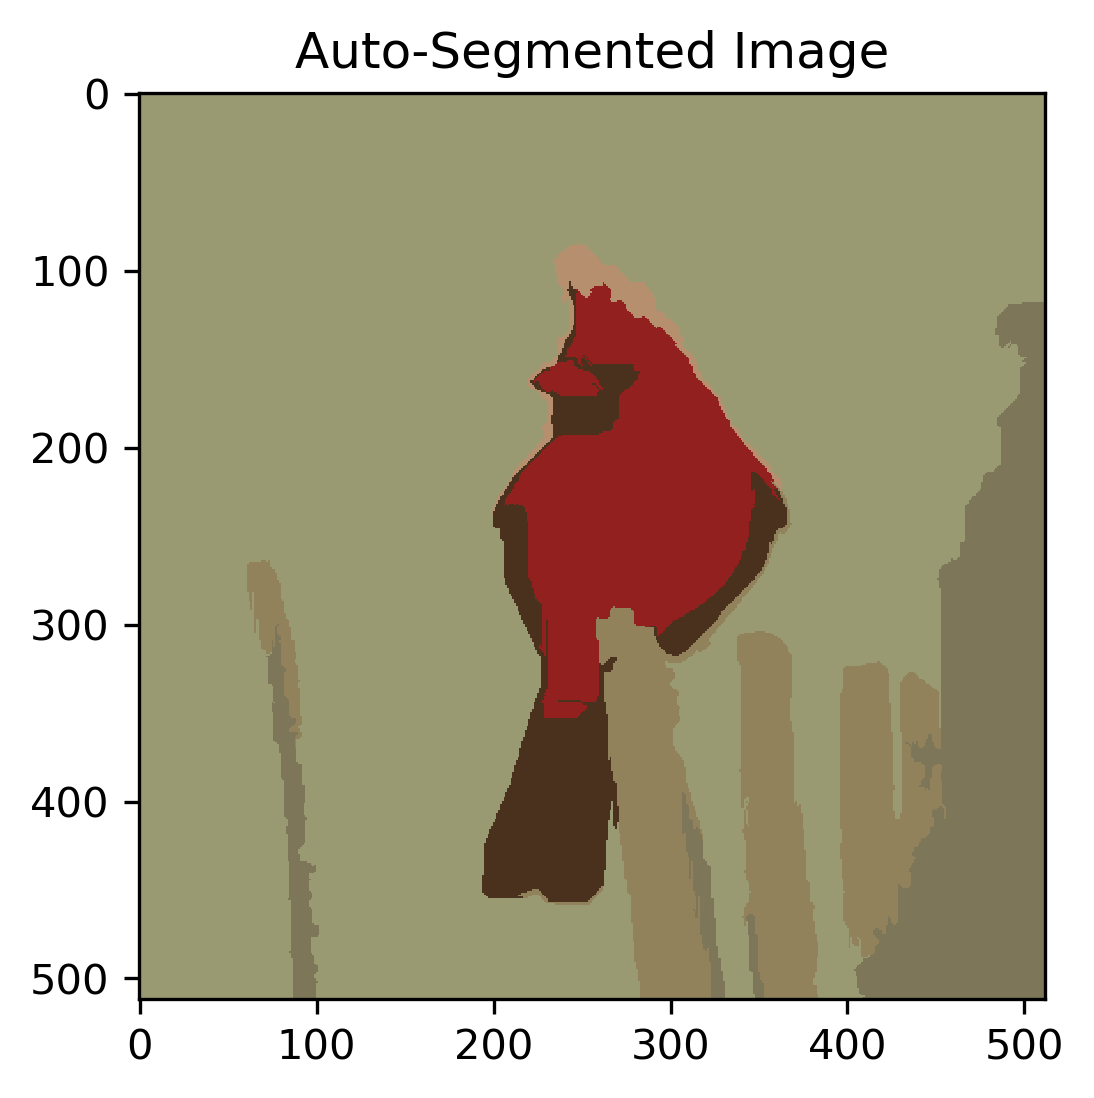

In [9]:
seg_map = segmentation.felzenszwalb(image, scale=128, sigma=1, min_size=64)
#seg_map = segmentation.slic(image, n_segments=3000, compactness=100)

seg_map = seg_map.flatten()
seg_lab = [np.where(seg_map == u_label)[0] for u_label in np.unique(seg_map)] 

# Initilizing library
t_0 = time.time()
# Strat CUDA devices
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# From (h,w,ch) -> (ch, h, w) format
tensor = image.transpose((2, 0, 1))
tensor = tensor.astype(np.float32) / 255.0
tensor = torch.from_numpy(tensor[np.newaxis, :, :, :]).to(device)

model = SEEK(n_features = feature_maps).to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    
summary(model, input_size=(3, img_h, img_w))
# Defining Loss and Optimizers
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum=0.9)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=init_lr, momentum=0.9)

# Generate a random color pallet for later use
color_avg = np.random.randint(255, size=(max_label_num, 3))
# Flatten image so that we can extract most appropriate mean pixel RGB values 
# from randomly created color pallet
image_flatten = image.reshape((-1, 3))

t_1 = time.time()

# Start Training
model.train()
for batch_idx in trange(Epoch, desc='Generating Segments [Epoch(s) Done]'):
    # Forward Propagation
    optimizer.zero_grad()
    output = model(tensor)[0]
    output = output.permute(1, 2, 0).view(-1, feature_maps)
    target = torch.argmax(output, 1)
    im_target = target.data.cpu().numpy()

    # Refine segments
    for inds in seg_lab:
        u_labels, hist = np.unique(im_target[inds], return_counts=True)
        im_target[inds] = u_labels[np.argmax(hist)]

    # Back propagation
    target = torch.from_numpy(im_target)
    target = target.to(device)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    # generate segmented image
    un_label, lab_inverse = np.unique(im_target, return_inverse=True, )
    if un_label.shape[0] < max_label_num:  # update show
        img_flatten = image_flatten.copy()
        if len(color_avg) != un_label.shape[0]:
            color_avg = [np.mean(img_flatten[im_target == label], axis=0, dtype=np.int) for label in un_label]
        for lab_id, color in enumerate(color_avg):
            img_flatten[lab_inverse == lab_id] = color
        show = img_flatten.reshape(image.shape)

    if len(un_label) < min_label_num:
        break

print('*'*50)
print('Loss after {0} Epoch(s)             = {1:.2f}'.format(batch_idx+1, loss.item()))
print('PyTorch Initilization time         = {0:.2f} second(s)'.format(time.time() - t_0))
print('Time Taken for generating segments = {0:.2f} second(s)'.format(time.time() - t_1))
print('*'*50)

# save image
show = cv2.cvtColor(show, cv2.COLOR_RGB2BGR)
cv2.imwrite("/home/user01/data_ssd/Talha/BSID500//out.png", show)
show = cv2.cvtColor(show,cv2.COLOR_BGR2RGB)
plt.imshow(show)
plt.title('Auto-Segmented Image')
plt.show()

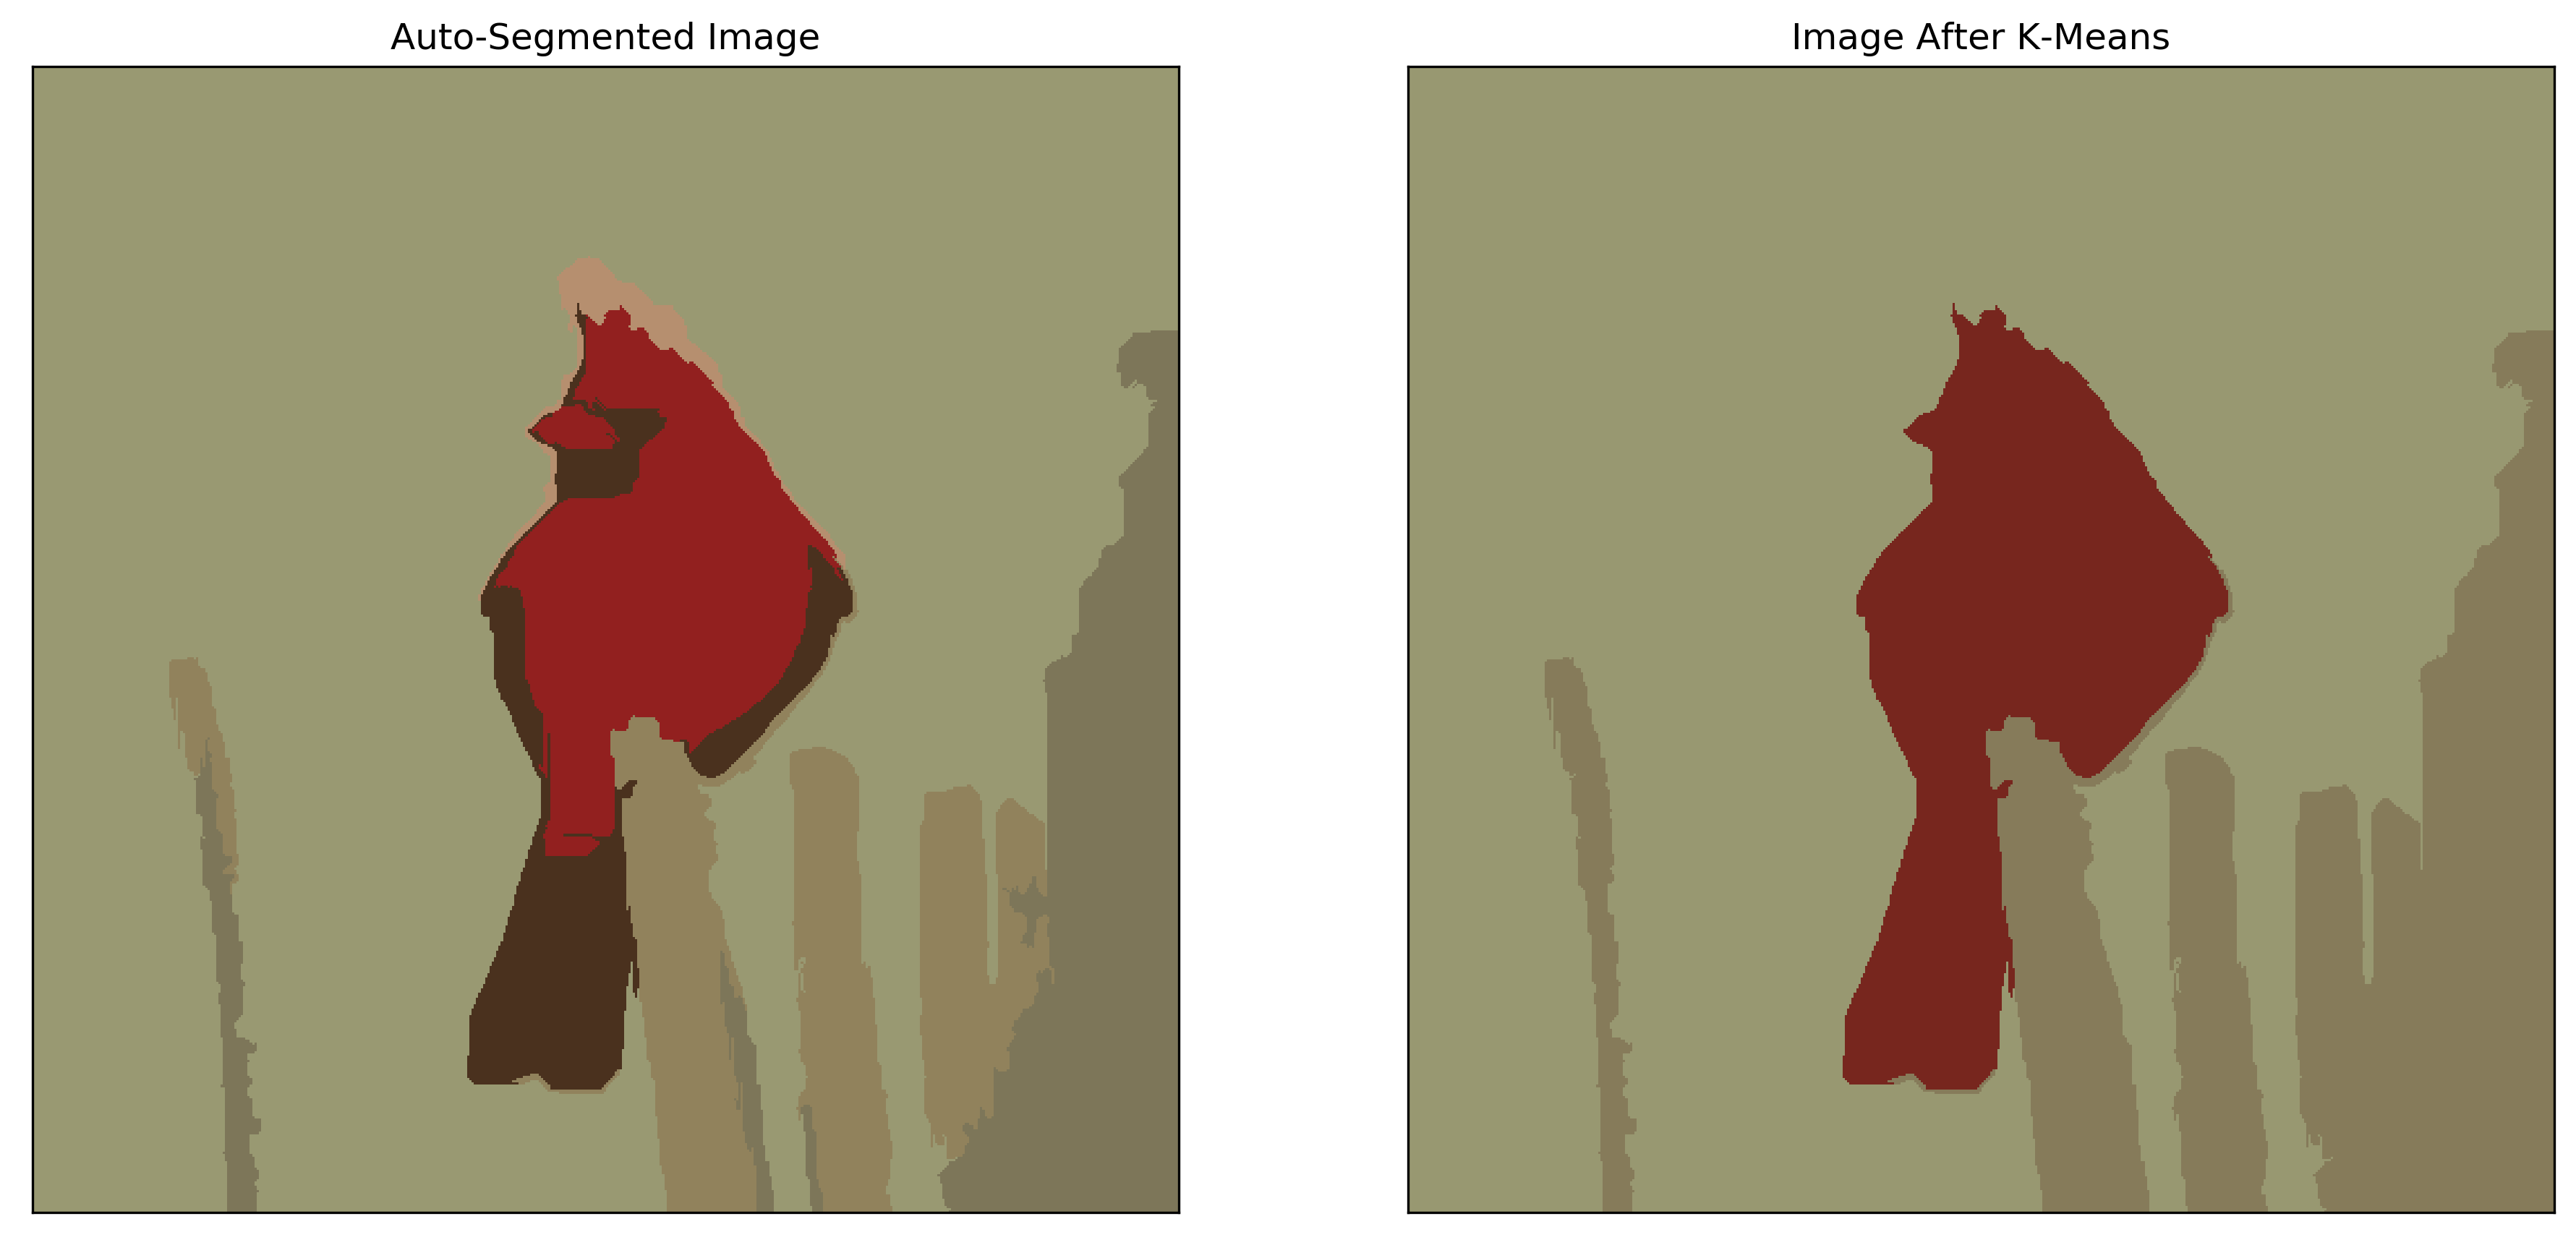

False

In [10]:
'''
Now we'll apply K-Means Clustering, but before that we need to get the value of 
'k' for deciding k-nearest neighbours for that we'll do following steps
'''
img1 = cv2.imread("/home/user01/data_ssd/Talha/BSID500/out.png")
# covnert to gray scale
gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
# get unique values 
g_uniq = np.unique(gray)
thresh = 10 # chose 10 or 15 as experiment values
t = []
for i in range(len(g_uniq)-1):
    if g_uniq[i+1] - g_uniq[i] > thresh:
        t.append(g_uniq[i])
        
K = len(t) + 1

img = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)

attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))

figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Auto-Segmented Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Image After K-Means'), plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite("/home/user01/data_ssd/Talha/Result/out_R.png", cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))